<img src="https://cdn.discordapp.com/attachments/1111599839663370271/1125364167927418950/Fake-news-banner.jpg">

# **Fake News Classifier using Embedding & LSTM**

---

In [126]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import datetime
import warnings
import nltk
import random
import re
import sklearn
import zipfile
import gensim
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt',download_dir="/kaggle/working/")
nltk.download('wordnet',download_dir="/kaggle/working/")
nltk.download('stopwords',download_dir="/kaggle/working/")
nltk.data.path.append('/kaggle/working/')

with zipfile.ZipFile("/kaggle/working/corpora/wordnet.zip", 'r') as zip_f:
    zip_f.extractall("/kaggle/working/corpora/")
    
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
%matplotlib inline
plt.style.use('dark_background')

[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Package stopwords is already up-to-date!


# Importing Dataset

In [127]:
news_data = pd.read_csv("/kaggle/input/fake-news/FakeNewsNet.csv")
news_data.dropna(inplace=True)
news_data.reset_index(inplace=True)
news_data.head()

,index,title,news_url,source_domain,tweet_num,real
0,0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


# Exploratory Data Analysis

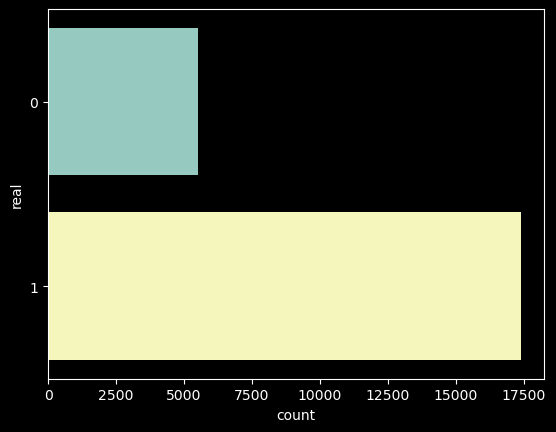

In [128]:
sns.countplot(data = news_data,y="real");

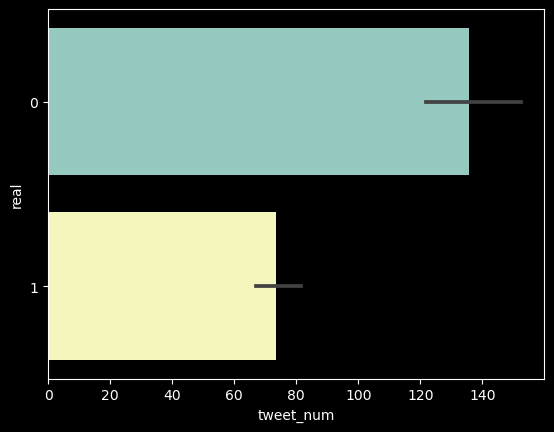

In [129]:
sns.barplot(data=news_data,y='real',x='tweet_num',orient="h");

# Processing 'URL'

In [130]:
def cleanURL(url):
    url = str(url)
    url = url.replace("www.","")
    url = url.replace("en.","")
    url = url.replace("web.","")
    url = url.replace("news.","")
    url = url.replace("uk.","")
    url = url.replace("sports.","")
    url = url.split(".")[0]
    return url

news_data["source_domain"] = news_data["source_domain"].apply(cleanURL)
len(news_data["source_domain"].unique())

2335

In [131]:
news_data.dropna(inplace=True)
news_data.drop(["news_url"],axis=1,inplace=True)

news_data.head()

,index,title,source_domain,tweet_num,real
0,0,Kandi Burruss Explodes Over Rape Accusation on...,toofab,42,1
1,1,People's Choice Awards 2018: The best red carp...,today,0,1
2,2,Sophia Bush Sends Sweet Birthday Message to 'O...,etonline,63,1
3,3,Colombian singer Maluma sparks rumours of inap...,dailymail,20,1
4,4,Gossip Girl 10 Years Later: How Upper East Sid...,zerchoo,38,1


# Text Preprocessing

In [132]:
stopwords = nltk.corpus.stopwords.words("english")

In [133]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemTitles(title):
    words = nltk.word_tokenize(title)
    words = [re.sub("[^a-zA-Z0-9]","",i).lower().strip() for i in words]
    words = [lemmatizer.lemmatize(i) for i in words if i not in stopwords]
    title = " ".join(words)
    return title

news_data["title"] = news_data["title"].apply(lemTitles)
news_data.head()

,index,title,source_domain,tweet_num,real
0,0,kandi burruss explodes rape accusation real ho...,toofab,42,1
1,1,people choice award 2018 best red carpet look,today,0,1
2,2,sophia bush sends sweet birthday message one t...,etonline,63,1
3,3,colombian singer maluma spark rumour inappropr...,dailymail,20,1
4,4,gossip girl 10 year later upper east siders s...,zerchoo,38,1


In [134]:
VOCAB_SIZE = 10000
DIMENSION = 500
MAXLEN = 25

In [135]:
def oneHot(title):
    return tf.keras.preprocessing.text.one_hot(title,VOCAB_SIZE)

news_data["title"] = news_data["title"].apply(oneHot)

In [136]:
news_data.shape

(22866, 5)

In [137]:
df = pd.DataFrame(tf.keras.utils.pad_sequences(news_data["title"],padding="pre",maxlen=MAXLEN))
df.shape

(22866, 25)

In [138]:
news_data = pd.concat((news_data,df),axis=1)
news_data.shape

(22866, 30)

In [139]:
news_data.head(3)

,index,title,source_domain,tweet_num,real,0,1,2,3,4,...,15,16,17,18,19,20,21,22,23,24
0,0,"[6270, 9380, 9086, 7568, 2008, 3330, 6690, 653...",toofab,42,1,0,0,0,0,0,...,6270,9380,9086,7568,2008,3330,6690,6539,9071,1671
1,1,"[5446, 9432, 4798, 901, 472, 1327, 1113, 8951]",today,0,1,0,0,0,0,0,...,0,0,5446,9432,4798,901,472,1327,1113,8951
2,2,"[9341, 5191, 3150, 6968, 5328, 6098, 2664, 419...",etonline,63,1,0,0,0,0,0,...,5328,6098,2664,4196,658,3851,5116,4401,7566,2372


# Model Creation

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, confusion_matrix

# cols = [i for i in news_data.columns if (i!="index" and i!="title" and i!="real")]
cols = [i for i in range(0,25)]
seed = np.random.seed(6)

X = news_data[cols]
y = news_data["real"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=seed)

In [141]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(VOCAB_SIZE,DIMENSION,input_length=len(cols)))
model.add(tf.keras.layers.LSTM(128,activation="tanh",return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64,activation="tanh",return_sequences=True))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(32,activation="tanh"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 25, 500)           5000000   
                                                                 
 lstm_23 (LSTM)              (None, 25, 128)           322048    
                                                                 
 dropout_14 (Dropout)        (None, 25, 128)           0         
                                                                 
 lstm_24 (LSTM)              (None, 25, 64)            49408     
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 25, 64)           0         
 lDropout1D)                                                     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                     

In [142]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3,start_from_epoch=5,restore_best_weights=True,)

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64, callbacks=[earlyStopping])

Epoch 1/20
268/268 [==============================] - 21s 56ms/step - loss: 0.4470 - accuracy: 0.8068 - val_loss: 0.3811 - val_accuracy: 0.8396
Epoch 2/20
268/268 [==============================] - 6s 21ms/step - loss: 0.3247 - accuracy: 0.8640 - val_loss: 0.3912 - val_accuracy: 0.8317
Epoch 3/20
268/268 [==============================] - 4s 13ms/step - loss: 0.2537 - accuracy: 0.8915 - val_loss: 0.4505 - val_accuracy: 0.8233
Epoch 4/20
268/268 [==============================] - 4s 16ms/step - loss: 0.1899 - accuracy: 0.9183 - val_loss: 0.5187 - val_accuracy: 0.8246
Epoch 5/20
268/268 [==============================] - 4s 15ms/step - loss: 0.1415 - accuracy: 0.9391 - val_loss: 0.6407 - val_accuracy: 0.8069
Epoch 6/20
268/268 [==============================] - 4s 14ms/step - loss: 0.1075 - accuracy: 0.9566 - val_loss: 0.7355 - val_accuracy: 0.8020
Epoch 7/20
268/268 [==============================] - 4s 15ms/step - loss: 0.0822 - accuracy: 0.9678 - val_loss: 0.8382 - val_accuracy: 0.808

# Model Evaluation

In [143]:
df = pd.DataFrame(history.history)
df_loss = df[['loss', 'val_loss']]
df_acc =  df[['accuracy', 'val_accuracy']]

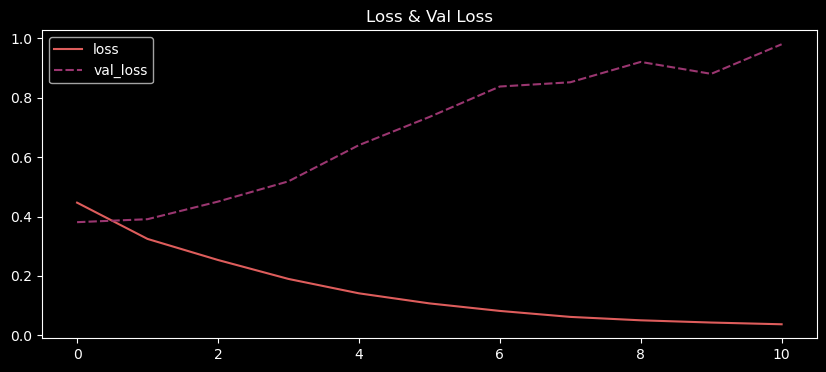

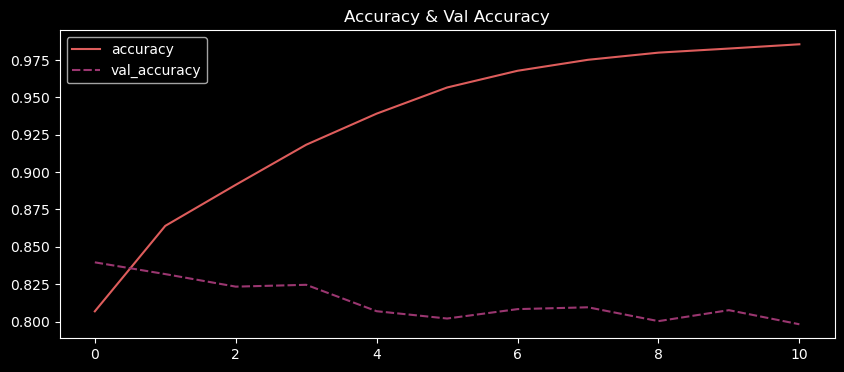

In [144]:
plt.figure(figsize=(10, 4))
plt.title("Loss & Val Loss")
sns.lineplot(df_loss,palette="flare");

plt.figure(figsize=(10, 4))
plt.title("Accuracy & Val Accuracy")
sns.lineplot(df_acc,palette="flare");

179/179 [==============================] - 2s 4ms/step


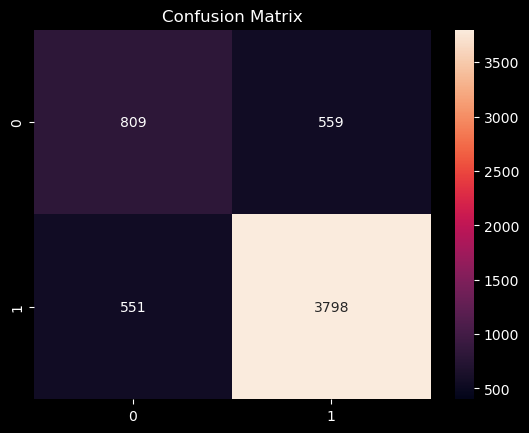

In [145]:
threshold = 0.6
y_pred = (model.predict(X_test) > threshold).astype("int32")
cnf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(cnf_matrix,annot=True,cmap="rocket",fmt=".5g",vmin=400,vmax=3800)
plt.title("Confusion Matrix");